# Set up workspace

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import glob
import pandas as pd
from scipy.stats import ttest_ind
from cartopy.util import add_cyclic_point
import cartopy.crs as ccrs
from eofs.xarray import Eof 

In [3]:
import sys
sys.path.append('/glade/u/home/czarakas/coupled_PPE/code/utils')

In [4]:
from load_ensembles import *
import quick_map
import load_gridcell_areas
from load_gridcell_areas import * 

# Load data

In [5]:
var1='calculated_PRECT'
var2='TS'
domain='atm'
ensemble='coupled'

In [6]:
end_spinup=60

#### Calculate area weights

In [7]:
landweights_approxAlaska=subset_landweights(latmax=80, 
                                            latmin=55, 
                                            lonmax=230, lonmin=190)

## Load full ensemble data

In [8]:
if ensemble=='coupled':
    ensemble_coupled1 = load_coupled_ensemble(var=var1, domain=domain, printon=False)
    ensemble_coupled2 = load_coupled_ensemble(var=var2, domain=domain, printon=False)
elif ensemble=='offline':
    ensemble_coupled1 = load_offline_ensemble(var=var1, domain=domain, printon=False)
    ensemble_coupled2 = load_offline_ensemble(var=var2, domain=domain, printon=False)

/glade/u/home/czarakas/coupled_PPE/code/utils/load_ensembles.py:46: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  ds = xr.open_mfdataset(fpath)
/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


In [9]:
if ensemble=='offline':
    if domain=='atm':
        basecase_lnd1=xr.open_dataset('/glade/campaign/cgd/tss/czarakas/CoupledPPE/offline_simulations/'+
                                 'OFFL0000_PI_v02/atm/proc/tseries/OFFL0000_PI_v02.cam.h0.timeseries.'+var1+'.nc')
        basecase_lnd2=xr.open_dataset('/glade/campaign/cgd/tss/czarakas/CoupledPPE/offline_simulations/'+
                                 'OFFL0000_PI_v02/atm/proc/tseries/OFFL0000_PI_v02.cam.h0.timeseries.'+var2+'.nc')
        #ref_tseries=basecase_lnd[var][end_spinup*12:,:,:].groupby('time.year').mean(dim='time')
    elif domain=='lnd':
        basecase_lnd1=xr.open_dataset('/glade/campaign/cgd/tss/czarakas/CoupledPPE/offline_simulations/'+
                                 'OFFL0000_PI_v02/lnd/proc/tseries/OFFL0000_PI_v02.clm2.h0.timeseries.'+var1+'.nc')
        basecase_lnd2=xr.open_dataset('/glade/campaign/cgd/tss/czarakas/CoupledPPE/offline_simulations/'+
                                 'OFFL0000_PI_v02/lnd/proc/tseries/OFFL0000_PI_v02.clm2.h0.timeseries.'+var2+'.nc')
       # ref_tseries=basecase_lnd[var][end_spinup*12:,:,:].groupby('time.year').mean(dim='time')
elif ensemble=='coupled':
    if domain=='atm':
        basecase_lnd1=xr.open_dataset('/glade/campaign/cgd/tss/czarakas/CoupledPPE/coupled_simulations/'+
                                 'COUP0000_PI_SOM/atm/proc/tseries/COUP0000_PI_SOM.cam.h0.timeseries.'+var1+'.nc')
        basecase_lnd2=xr.open_dataset('/glade/campaign/cgd/tss/czarakas/CoupledPPE/coupled_simulations/'+
                                 'COUP0000_PI_SOM/atm/proc/tseries/COUP0000_PI_SOM.cam.h0.timeseries.'+var2+'.nc')
       # ref_tseries=basecase_lnd[var][end_spinup*12:,:,:].groupby('time.year').mean(dim='time')
    elif domain=='lnd':
        basecase_lnd1=xr.open_dataset('/glade/campaign/cgd/tss/czarakas/CoupledPPE/coupled_simulations/'+
                                 'COUP0000_PI_SOM/lnd/proc/tseries/COUP0000_PI_SOM.clm2.h0.timeseries.'+var1+'.nc')
        basecase_lnd2=xr.open_dataset('/glade/campaign/cgd/tss/czarakas/CoupledPPE/coupled_simulations/'+
                                 'COUP0000_PI_SOM/lnd/proc/tseries/COUP0000_PI_SOM.clm2.h0.timeseries.'+var2+'.nc')

In [10]:
from load_gridcell_areas import *

## Make a data array that stacks all the differences from the reference 
(i.e. dimension are [lat, lon, num_ensemble_simulations]

In [11]:
ds_grid1 = ensemble_coupled1[0]
ds_grid2 = ensemble_coupled2[0]

In [19]:
ds=ensemble_coupled1[0].mean(dim='time')
var='calculated_PRECT'
ds[var].sel(lat=slice(15, 80), lon=slice(360-140,360-60)).values.flatten()

array([1.9947292e-08, 1.9141076e-08, 1.8514646e-08, ..., 6.6022365e-09,
       6.5573604e-09, 6.5790333e-09], dtype=float32)

In [11]:
import make_multisimulation_dataset

In [12]:
var_array1 = make_multisimulation_dataset.make_empty_dataarray(ds_grid=ds_grid1, var=var1, keys=keys)
var_array2 = make_multisimulation_dataset.make_empty_dataarray(ds_grid=ds_grid2, var=var2, keys=keys)

In [13]:
# area dataArray
ds_to_analyze=var_array1[:,:,0]
da_area = area_grid(ds_to_analyze.lat, ds_to_analyze.lon)
# total area
total_area = da_area.sum(['lat','lon'])
#  weighted by grid-cell area
areaweights = (da_area) / total_area

In [14]:
if domain=='atm':
    landweights=landweights.reindex_like(areaweights, tolerance=0.05, method='nearest')
    landweights_approxAlaska=landweights_approxAlaska.reindex_like(areaweights, tolerance=0.05, method='nearest')

In [156]:
season='Annual'#'Annual','DJF,'MAM','JJA','SON'

if season=='Annual':
    ref_tseries=basecase_lnd1[var1][end_spinup*12:,:,:].groupby('time.year').mean(dim='time')
else:
    seasonfilter=basecase_lnd1[var1]['time.season']==season
    ref_tseries=basecase_lnd1[var1][end_spinup*12:,:,:].where(seasonfilter).groupby('time.year').mean(dim='time')
for i in np.arange(0,np.size(keys)):
    print(i)
    if season=='Annual':
        this_ensemble_tseries=ensemble_coupled1[i][var1][end_spinup*12:,:,:].groupby('time.year').mean(dim='time')
    else:
        seasonfilter=ensemble_coupled1[i][var1]['time.season']==season
        this_ensemble_tseries=ensemble_coupled1[i][var1][end_spinup*12:,:,:].where(seasonfilter).groupby('time.year').mean(dim='time')
    #t, p = ttest_ind(this_ensemble_tseries, ref_tseries, equal_var=False)
    diff = this_ensemble_tseries.mean(dim='year')-ref_tseries.mean(dim='year')
    
    var_array1[:,:,i]=diff
   # var_array_pvals[:,:,i]=p

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35


In [157]:
if season=='Annual':
    ref_tseries=basecase_lnd2[var2][end_spinup*12:,:,:].groupby('time.year').mean(dim='time')
else:
    seasonfilter=basecase_lnd2[var2]['time.season']==season
    ref_tseries=basecase_lnd2[var2][end_spinup*12:,:,:].where(seasonfilter).groupby('time.year').mean(dim='time')
for i in np.arange(0,np.size(keys)):
    print(i)
    if season=='Annual':
        this_ensemble_tseries=ensemble_coupled2[i][var2][end_spinup*12:,:,:].groupby('time.year').mean(dim='time')
    else:
        seasonfilter=ensemble_coupled2[i][var2]['time.season']==season
        this_ensemble_tseries=ensemble_coupled2[i][var2][end_spinup*12:,:,:].where(seasonfilter).groupby('time.year').mean(dim='time')
    #t, p = ttest_ind(this_ensemble_tseries, ref_tseries, equal_var=False)
    diff = this_ensemble_tseries.mean(dim='year')-ref_tseries.mean(dim='year')
    
    var_array2[:,:,i]=diff
   # var_array_pvals[:,:,i]=p

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35


In [113]:
var_array_bymonth2 = make_multisimulation_dataset.make_empty_dataarray(ds_grid=ds_grid1, var=var1, keys=keys)
var_array_bymonth2 = var_array_bymonth2.expand_dims(dim={"month": 12}).copy()

ref_tseries=basecase_lnd2[var2][end_spinup*12:,:,:].groupby('time.month').mean(dim='time')
for i in np.arange(0,np.size(keys)):
    this_ensemble_tseries=ensemble_coupled2[i][var2][end_spinup*12:,:,:].groupby('time.month').mean(dim='time')
    diff = this_ensemble_tseries-ref_tseries
    var_array_bymonth2[:,:,:,i]=diff.values

In [114]:
var_array_bymonth1 = make_multisimulation_dataset.make_empty_dataarray(ds_grid=ds_grid1, var=var1, keys=keys)
var_array_bymonth1 = var_array_bymonth1.expand_dims(dim={"month": 12}).copy()

ref_tseries=basecase_lnd1[var1][end_spinup*12:,:,:].groupby('time.month').mean(dim='time')
for i in np.arange(0,np.size(keys)):
    this_ensemble_tseries=ensemble_coupled1[i][var1][end_spinup*12:,:,:].groupby('time.month').mean(dim='time')
    diff = this_ensemble_tseries-ref_tseries
    var_array_bymonth1[:,:,:,i]=diff.values

In [55]:
descriptions = []
for key in var_array1.ensemble_key.values:
    if np.nansum(crosswalk.Key_short==key)>0:
        descriptions.append(crosswalk.description[crosswalk.Key_short==key].values[0])
    else:
        print('Error')
     #   descriptions.append('0000')
    #print(key)#ensemble_coupled=load_coupled_ensemble(var=var)

# Temperature impacts

In [121]:
Alaska_changes_bymonth=(var_array_bymonth*landweights_approxAlaska).mean(dim=['lat','lon'])
Alaska_changes_bymonth1=(var_array_bymonth1*landweights_approxAlaska).mean(dim=['lat','lon'])

In [158]:
Alaska_changes1=(var_array1*landweights_approxAlaska).mean(dim=['lat','lon'])
Alaska_changes2=(var_array2*landweights_approxAlaska).mean(dim=['lat','lon'])

In [159]:
unit_conversion1=86400*1000
unit_conversion2=1

In [160]:
crosswalk[var1+'_Alaska_'+season]=np.nan
crosswalk[var2+'_Alaska_'+season]=np.nan

for i, desc in enumerate(var_array1.ensemble_key.values):
    crosswalk[var1+'_Alaska_'+season][i+1]=Alaska_changes1.values[i]
    crosswalk[var2+'_Alaska_'+season][i+1]=Alaska_changes2.values[i]
    
crosswalk[var1+'_Alaska_'+season]=crosswalk[var1+'_Alaska_'+season]*unit_conversion1
crosswalk[var2+'_Alaska_'+season]=crosswalk[var2+'_Alaska_'+season]*unit_conversion2

/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


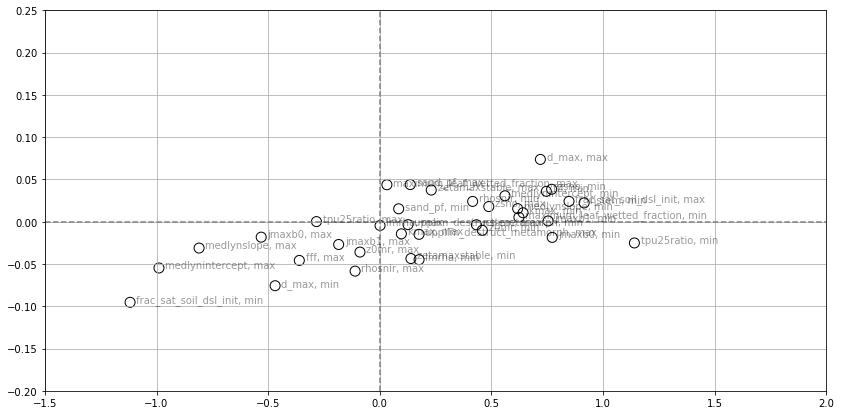

In [207]:
season='Annual'
plt.figure(figsize=(14,7))
x=crosswalk['TS_Alaska_'+season].values
y=crosswalk['calculated_PRECT_Alaska_'+season].values
for i,param in enumerate(crosswalk.param.values):
    if np.abs(x[i])>0:
        plt.annotate(crosswalk.description.values[i], (x[i]+0.028,y[i]),alpha=0.4)
plt.scatter(x,
         y,facecolor='none',edgecolor='k', s=100)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axvline(x=0,linestyle='--',color='gray')
plt.xlim([-1.5, 2])
plt.ylim([-0.2, 0.25])
plt.grid()
plt.savefig('DeltaT_vs_deltaP_'+season+'.png')

In [90]:
params=['frac_sat_soil_dsl_init', 
        'medlynintercept','tpu25ratio','medlynslope',
        'jmaxb0', 'd_max', 'fff', 
        'jmaxb1',
       'maximum_leaf_wetted_fraction', 'kmax',  
        'rhosnir',  'z0mr', 'nstem', 'zsno','lmrha',
        'upplim_destruct_metamorph','zetamaxstable','sand_pf']

In [91]:
param_colors=['skyblue', 
        'forestgreen','lightseagreen','forestgreen',
        'lightseagreen', 'skyblue', 'skyblue', 
        'lightseagreen',
       'orange', 'forestgreen',  
        'goldenrod',  'purple', 'orange', 'purple','lightgreen',
        'purple','purple','skyblue']

In [92]:
temp = np.array(sensitivities).argsort()
ranks = np.arange(len(sensitivities))[temp.argsort()]

In [76]:
ranks

array([ 6,  2, 15, 16, 13, 14,  4, 12, 17,  7,  0,  8,  3,  5, 11,  1,  9,
       10])

In [77]:
np.sort(np.abs(sensitivities))

array([ 1.41056518,  5.39406702, 12.97319742, 13.70916478, 15.25997563,
       21.19477046, 21.30042316, 22.86508464, 25.73836274, 29.92845452,
       31.40612979, 33.5730163 , 41.50541285, 47.04331986, 58.72616198,
       60.53658088, 61.46610776, 90.94767004])

-1.41
0
-25.74
1
60.54
2
61.47
3
47.04
4
58.73
5
-12.97
6
41.51
7
90.95
8
13.71
9
-31.41
10
15.26
11
-21.19
12
-5.39
13
33.57
14
-29.93
15
21.3
16
22.87
17


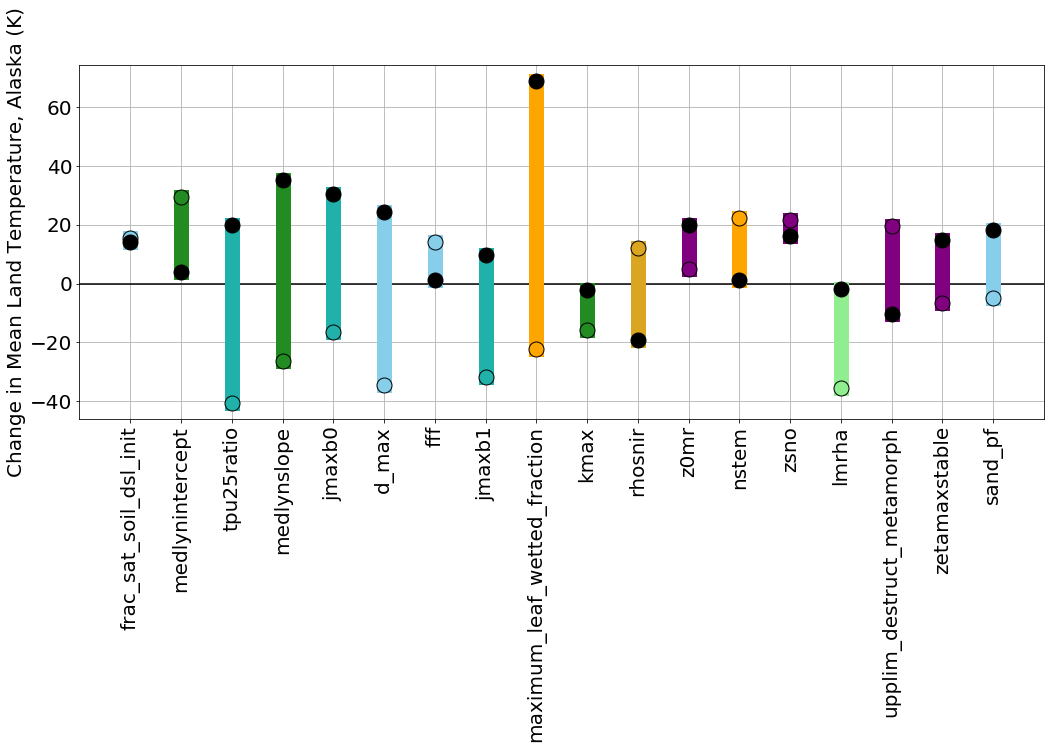

In [93]:
plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 20})
plt.plot([-1,np.size(params)],[0,0],'-k')
sensitivities=[]
paramticks=[]
for i, param in enumerate(params):
    minval=crosswalk[var+'_Alaska'].values[crosswalk.description==param+', min'][0]
    maxval=crosswalk[var+'_Alaska'].values[crosswalk.description==param+', max'][0]
    print(np.round(maxval-minval,2))
    sensitivities.append(maxval-minval)
    xval=i
    print(xval)
    plt.plot([xval,xval], [minval,maxval],'-', linewidth=15, color=param_colors[i])
    plt.plot([xval], [minval],'ok', fillstyle='none',markersize=15)
    plt.plot([xval], [maxval],'ok', fillstyle='full',markersize=15)
    paramticks.append(param)

plt.xticks(np.arange(0, i+1), paramticks, rotation='vertical')
plt.grid()
plt.xlim([-1,np.size(params)])
plt.ylabel('Change in Mean Land Temperature, Alaska (K)')
plt.tight_layout()
plt.savefig('Mean_Land_Temperature.png')

In [169]:
landweights_approxAlaska_subset=landweights_approxAlaska.where((landweights_approxAlaska.lat<=80)&
                               (landweights_approxAlaska.lat>=55)&
                               (landweights_approxAlaska.lon<=230)&
                               (landweights_approxAlaska.lon>=190), drop=True)

In [170]:
landmask_approxAlaska=~np.isnan(landweights_approxAlaska_subset)

In [171]:
def quick_map_subplot(mapdata_for_subplot, lat, lon, nrow=3, ncol=3, ind=1, title=None, cb_ttl=None,
              cmap=None, clim=None, filepath=None, sighatch=False,
              p=None, sigmask=None, markerstyle='x', markersize=1.0, norm=None):
    """ Creates map """
    ax = plt.subplot(nrow, ncol, ind+1, projection=ccrs.PlateCarree())
    ax.coastlines(resolution='110m') #learn how to add resolution here??
    #ax.set_global()

    cyclic_data, cyclic_lons = add_cyclic_point(mapdata_for_subplot, coord=lon)

    if norm:
        cs = plt.pcolormesh(cyclic_lons, lat, cyclic_data,
                            transform=ccrs.PlateCarree())
    else:
        cs = plt.pcolormesh(cyclic_lons, lat, cyclic_data,
                            transform=ccrs.PlateCarree(), norm=norm)

    # Choose your colormap
    if cmap:
        plt.set_cmap(cmap)
    else:
        plt.set_cmap(plt.cm.viridis)

    ax.patch.set_alpha(1.0)
        
    plt.title(title, fontsize=8)

    if clim:
        plt.clim(clim)
        cs.set_clim(clim[0], clim[1])
        cs.set_clim(clim)
    
    cbar = plt.colorbar(ax=ax, orientation='horizontal',
                            extend='both', pad=.02, shrink=0.9, norm=norm)
    cbar.ax.tick_params(labelsize=14)

    if clim:
        cbar.set_clim(clim)

    if cb_ttl:
        cbar.set_label(cb_ttl, fontsize=20)

In [188]:
order_to_plot=[0, 1,2,3,4,5,
               6,7,8,9,10,11,
               12,25,13,27,14,15,
               16, 26,17,18,19,20,
               21,22,23,24,28,29,
               30,31,32,33,34,35]

/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: 
The set_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_clim instead.
/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  if sys.path[0] == '':


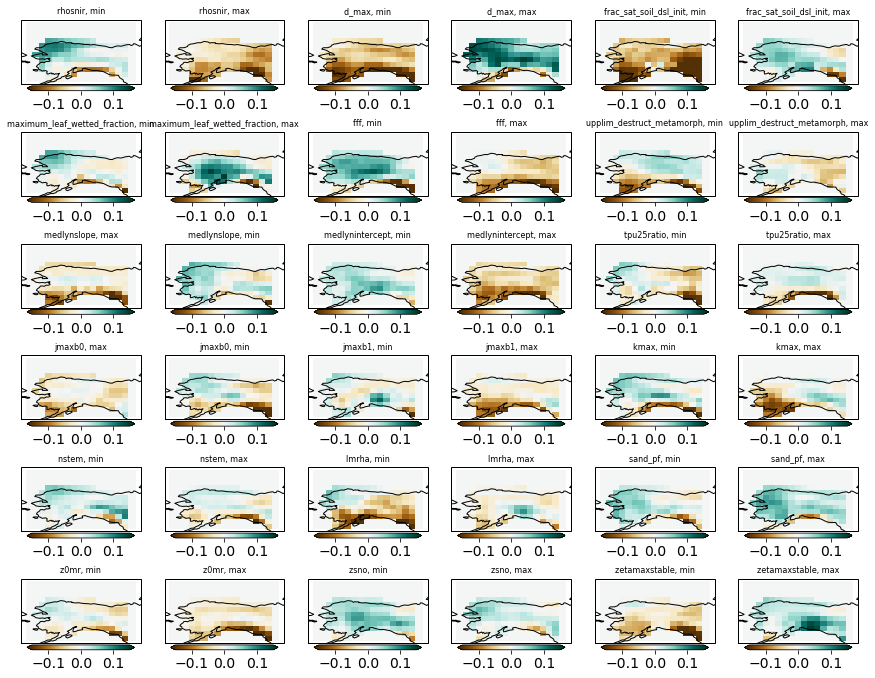

In [191]:
plt.figure(figsize=(15,12))
for j,desc in enumerate(crosswalk.description.values):
    i=order_to_plot[j]
    title=crosswalk.description.values[i]
    #print('------')
    #print(j)
    #print(i)
    mapdata_for_subplot=var_array1[:,:,i]*landmask_approxAlaska*unit_conversion1
    quick_map_subplot(mapdata_for_subplot, mapdata_for_subplot.lat, 
                      mapdata_for_subplot.lon, nrow=6, ncol=6, ind=j,
                      cmap=plt.cm.BrBG, clim=[-0.15,0.15],title=title)
plt.tight_layout()
plt.savefig('Precipitation_change_maps.png')